In [11]:
import numpy as np
import matplotlib.pyplot as plt



#### NOTE: hbar and k_B are equal to 1

In [14]:
def density_of_states_behte_non_int (omega, D):
    '''
    density of states of a Bethe lattice with infinite connectivity 
    (from the analytical expression of the non interacting GF)

    input:      omega       real frequency/energy 
                D           bandwidth, the density of states is non zero for |omega|<D

    output:     rho(omega)  densiy of states, rho(w)=2*sqrt(D^2-w^2)/pi*D^2
    '''

    return 2*np.sqrt(D**2-omega**2)/np.pi*D**2



/var/folders/p9/vmfpstws7vd67rl49m49vhxr0000gq/T/ipykernel_16290/3915838211.py:12: RuntimeWarning: invalid value encountered in sqrt
  return 2*np.sqrt(D**2-omega**2)/np.pi*D**2


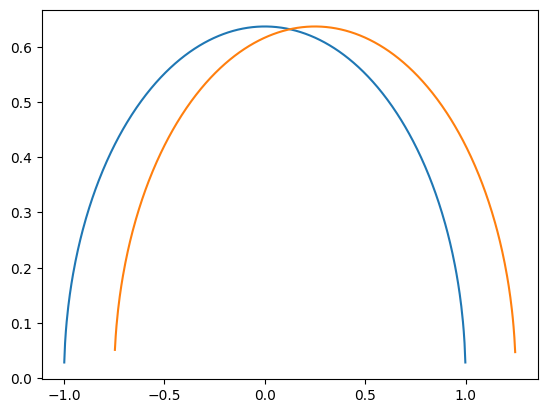

In [7]:
ww = np.linspace(-2.,2.,1000)
rho_bethe = density_of_states_behte_non_int(omega=ww, D=1.)
plt.plot(ww, rho_bethe)


# I introduce a chemical potential: rho(e)->rho(e-mu)
mu = 0.25
rho_bethe_mu= density_of_states_behte_non_int(omega=ww-mu, D=1.)
plt.plot(ww, rho_bethe_mu)

In [80]:
### TODO: CHECK HOW MANY INTEGRAL STEPS
energy_integral_steps = 10000

### TODO: generalize to the non half-filling case
## - change integral extremes
## - change density of states

def local_int_greens_func(iomega, density_of_states, local_self_energy, D):
    '''
    local interacting Green's function (step 2):
    
    input:      iomega                            matzubara frequency 
                density_of_states(omega, D)       function of omega and the bandwidth
                local_self_energy(iomega)         number local self energy at the current Matzubara frequency (of the reference embedded site) as encoded in step (1)
                D                                 bandwidth ---> corresponding to the symmetric extremes of the integral

    output:     G_loc(iomega)   local interacting GF(iw)=int (de*rho(e) 1/(iw-e-Sigma_loc(iw)))        
    '''

    energy = np.linspace(start=-D, stop=D, num=energy_integral_steps)
    Rho_e = density_of_states(energy, D)
    Sigma_loc = local_self_energy

    return np.sum(Rho_e/(iomega*np.ones_like(energy)-energy-Sigma_loc*np.ones_like(energy)))*(2*D)/energy_integral_steps



In [81]:
def impurity_non_int_greens_func(iomega, local_greens_func, local_self_energy):
    '''
    non interacting Green's function of the auxiliary system
    (step (3): find G_0 coursive)

    input:      iomega                       matzubara frequency 
                local_greens_func(iomega)    function of omega: local interacting Green's function (of the reference embedded site) as encoded in step (2)
                local_self_energy(iomega)    function of omega: local self energy (of the reference embedded site) as encoded in step (1)

    output:     G_0 coursive(iomega)         non interacting GF of the auxiliary system, G_0 coursive(w)=(G_loc^-1+Sigma_loc)^-1
    '''

    G_loc = local_greens_func(iomega)
    Sigma_loc = local_self_energy(iomega)

    return 1/( (1/G_loc) + Sigma_loc )

In [82]:
N_cutoff = 1000
##### TODO:  CHECK THE CUTOFF FOR EVALUATING THE SUM IN THE FOURIER TRANSFORM  ############

def fourier_trans_to_imag_time(func, beta, tau):
    '''
    Fourier transform of a function G(i*omega_n) where i*omega_n are Matzubara frequencies
    (needed to perform the Iterative Perturbation Theory Step)
    
    input:      func        G(i*omega_n): function of i*omega (Matzubara frequencies)
                beta        inverse temperature
                tau         imaginary time        

    output:     G(tau)      function of the imaginary time (tau), G(tau)=(1/beta)* sum_(w_n)  (e^i*w_n*tau)*G(i*omega_n)
    '''

    nn = range(start=-N_cutoff, stop=N_cutoff)
    matz_frequencies = np.pi*(1/beta) * (2*nn + 1)
    
    G_iw = func(matz_frequencies)
    exponential_iw = np.exp(-1j * matz_frequencies*tau)

    return  np.sum(exponential_iw*G_iw) / beta


In [83]:
########### TODO: find limits of integration for the integral in time!!!  
time_integral_steps=10000

def iterative_perturbation_theory_impurity_solver(impurity_non_int_greens_func, iomega, U, beta):
    '''
    finds the self energy of the auxiliary Anderson impurtity model Sigma_imp
    from this it evaluates also the interacting Green's function of the auxiliary system (G coursive)

    input:      impurity_non_int_greens_func        G_0 (iomega) coursive: non interacting Green's function of the auxiliary system
                                                                           encoded in step (3) and evaluated on Matzubara frequency
                iomega                              Matzubara frequency i*omega_n
                U                                   impurity interaction
                beta                                inverse temperature  

    output:     impurity_self_energy(iomega)        self energy of the auxiliary system    Sigma_imp(iw)=U/2 + U^2 * int_0^beta d(tau) (e^i*w_n*tau) * G_0^shifted(tau)^3
                                                                                           knowing G_0^shifted(iw)= (G_0(iw)^-1  - U/2)^-1     where all the G are coursive
                impurity_int_greens_func(iomega)    interacting GF of the auxiliary system   G(iw) = (  G_0(iw)^-1 - Sigma_imp(iw)  )^-1          where all the G are coursive

    note: this fucntion uses the function fourier_trans_to_imag_time() to convert G_0^shifted(iw) coursive in imaginary time
    '''

    # I calculate G_0_shifted(iw) as a function of iomega
    shifted_impurity_non_int_greens_func = lambda iw : 1 / ( (1/impurity_non_int_greens_func(iw)) - U*0.5 )

    # I calculate the fourier transform G_0_shifted(tau)
    tau = np.linspace(start=0, stop=beta, num=time_integral_steps)
    G_0_shifted_tau = fourier_trans_to_imag_time(shifted_impurity_non_int_greens_func, beta, tau)
    exponential_tau = np.exp(1j * iomega*tau)


    # I calculate the integral
    integral = np.sum(exponential_tau * G_0_shifted_tau**3)

    # I get Sigma_imp and the interacting GF of the impurity
    Sigma_imp = U*0.5 + U**2  * integral

    G_0_iw = impurity_non_int_greens_func(iomega)
    G_imp = 1 / ( 1/G_0_iw + Sigma_imp )
    return Sigma_imp, G_imp



In [84]:
def pade_analytic_contituation(wn, gf, norb = 1, nw = 500, nw_out = 1000, emin = -10.0, emax = 10.0, delta = 0.000000001):
	'''
	perform the analytic continuation form Matzubara frequencies to real frequencies of the green's function gf

	input:			wn[n]       imaginay part of the Matzubara frequencies n=0,...nw-1=500 matzubara frequencies
					gf[m,n]     green's function in Matzubara frequencies, m=0,...norb-1=1, n=0,...nw-1=500 matzubara frequencies
					norb		number of orbitals
					nw			number of matzubara frequencies
					nw_out		number of real output frequencies
					emin, emax	minimum and maximum of real frequency for the output GF
					delta       small parameter for the pade algorithm

	output:         gf_out[m,n]   green's function in real frequencies, m=0,...norb-1=1, n=0,...nw_out-1=1000 real frequencies
	'''

	de = (emax-emin)/nw_out

	# pade
	pmatrix = np.zeros((norb,nw,nw),dtype=complex)
	for m1 in range(norb):
		for n in range(nw):
			pmatrix[m1,0,n] = gf[m1,n]

		for m in range(1,nw):
			for n in range(1,m+1):
				if ( abs(pmatrix[m1,n-1,m]) < delta ):
					continue
				pmatrix[m1,n,m] = ( pmatrix[m1,n-1,n-1] - pmatrix[m1,n-1,m] ) / ( pmatrix[m1,n-1,m]*1.0j*( wn[m]-wn[n-1] ) )


	gf_out = np.zeros((norb,nw_out),dtype=complex)
	for nn in range(nw_out):
		# w  is the current real frequency
		w = emin + nn*de

		for m1 in range(norb):

			# find good n
			nstart = 0
			for m in range(nw):
				if ( abs(pmatrix[m1,m,m])<delta ):
					break
				nstart += 1
			nstart = min(nstart,nw-1)
			nstart = nw-1

			val = 1.0 + pmatrix[m1,nstart,nstart]*( w - 1.0j*wn[nstart-1] )
			for m in range(nstart-1,0,-1):
				val = 1.0 + pmatrix[m1,m,m]*( w - 1.0j*wn[m-1] )/val
			val = pmatrix[m1,0,0]/val

			# val is the current value of the green's function in real frequencies
			gf_out[m1, nn]=val
	
	return gf_out

/var/folders/p9/vmfpstws7vd67rl49m49vhxr0000gq/T/ipykernel_16290/2448444855.py:12: RuntimeWarning: invalid value encountered in sqrt
  return 2*np.sqrt(D**2-omega**2)/np.pi*D**2


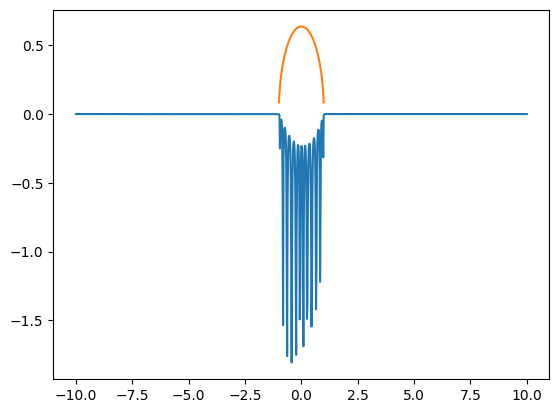

In [85]:
beta=20
D = 1.0
N_iomega=501

nn = np.linspace(start=-(N_iomega-1)/2, stop=(N_iomega-1)/2, num=N_iomega, dtype=int)
iomega = 1j*np.pi*(2*nn+1)/beta


# step 1: set Sigma_loc
Sigma_loc = np.zeros(N_iomega)

# step 2: get local GF
GF_loc=np.zeros(N_iomega)+1j*np.zeros(N_iomega)
for n in nn:
    GF_loc[n]=local_int_greens_func(iomega=iomega[n], density_of_states=density_of_states_behte_non_int, local_self_energy=Sigma_loc[n], D=D)

# vizualization: transform to real frequencies:
N_energy = 1000
emin = -10.0
emax = 10.0
energy = np.linspace(emin, emax, N_energy)

GF_loc_real_freq = pade_analytic_contituation(wn=iomega.imag, gf=GF_loc.reshape((1,N_iomega)))[0]
plt.plot(energy, -GF_loc_real_freq.imag/np.pi)
plt.plot(energy, density_of_states_behte_non_int(energy,D))

/var/folders/p9/vmfpstws7vd67rl49m49vhxr0000gq/T/ipykernel_16290/2448444855.py:12: RuntimeWarning: invalid value encountered in sqrt
  return 2*np.sqrt(D**2-omega**2)/np.pi*D**2


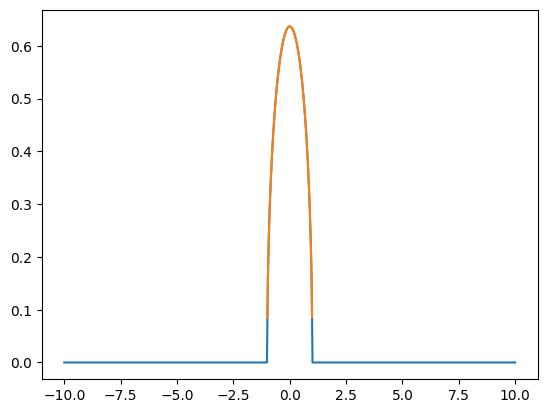

In [86]:
# analytic formula non int gf bethe
gf_non_int=2/(D**2) * (energy - np.sqrt(energy**2-D**2, dtype=complex))

plt.plot(energy, -gf_non_int.imag/np.pi)
plt.plot(energy, density_of_states_behte_non_int(energy,D))

In [87]:
# gf on matzubara freq
gf_non_int_matz=2/(D**2) * (iomega - np.sqrt(iomega**2-D**2, dtype=complex))
gf_non_int_real_freq = pade_analytic_contituation(wn=iomega.imag, gf=gf_non_int_matz.reshape((1,N_iomega)))[0]

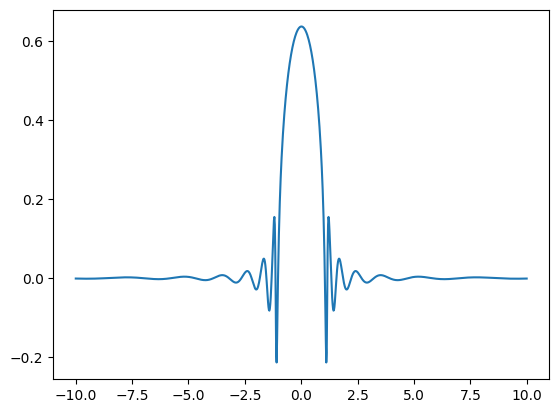

In [88]:
plt.plot(energy, -gf_non_int_real_freq.imag/np.pi)

In [119]:
# try again step 2:
N = 505
omega_n=np.pi/beta*(2*np.array(range(-N,N))+1)

def get_Gloc(density_of_states,omega_n):

    t=D
    sigma_imp=0.
    eps=np.linspace(-t,t,len(omega_n))
    rho = density_of_states(eps,D)

    Gloc=np.zeros(len(omega_n))+0*1j
    d_eps=(eps[-1]-eps[0])/len(eps)
    print(d_eps)
    for i in range(len(eps)):
        Gloc += rho[i]/(omega_n-eps[i]-sigma_imp)*d_eps
    return Gloc

Gloc=get_Gloc(density_of_states=density_of_states_behte_non_int,omega_n=1j*omega_n)

0.0019801980198019802


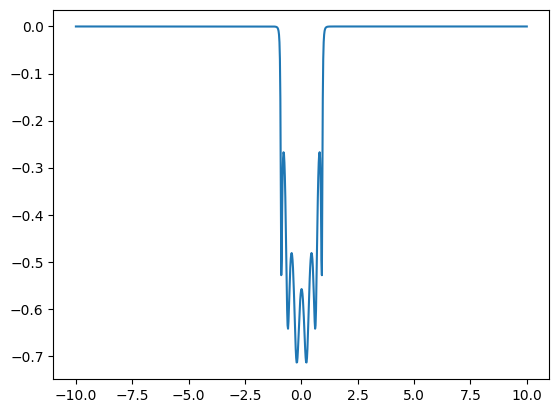

In [120]:
gf_non_int_real_freq = pade_analytic_contituation(wn=omega_n, gf=Gloc.reshape((1,2*N)))[0]
plt.plot(energy, -gf_non_int_real_freq.imag/np.pi)